In [1]:
# ==========================================
#  IMPORTS
# ==========================================

In [2]:
import time
start_time = time.perf_counter()

In [3]:
# ==========================================
#  FUNCTIONS
# ==========================================

In [4]:
def normalize(A):
    """Min-Max normalization to [0, 1]."""
    A = A.astype(float)
    m1, m2 = A.min(), A.max()
    if m1 == m2:
        return A
    return (A - m1) / (m2 - m1)

In [5]:
import numpy as np
def matrix_bin_stats(matrix):
    # Matrix dimensions
    print(f"Dimensions: {matrix.ndim}")
    # Matrix shape
    print(f"Shape: {matrix.shape}")
    # Matrix elements
    elements=matrix.size
    print(f"Elements: {elements}")
    # Count 1s (True)
    ones = np.count_nonzero(matrix)
    # Count 0s (False)
    zeros = matrix.size - ones
    print(f"Ones: {ones}, Zeros: {zeros}, Total: {zeros+ones}")
    print(f"Ones: {round(ones/elements*100,1)} %, Zeros: {round(zeros/elements*100,1)}, Total: {round((zeros+ones)/elements*100,1)}")
    return zeros/elements

In [6]:
import numpy as np
def matrix_non_bin_stats(matrix):
    # Matrix dimensions
    print(f"Dimensions: {matrix.ndim}")
    # Matrix shape
    print(f"Shape: {matrix.shape}")
    # Matrix elements
    elements=matrix.size
    print(f"Elements: {elements}")
    # Define your custom bin edges
    # These represent: [0, 0.2), [0.2, 0.40), [0.40, 0.60), [0.60, 0.80), [0.80, 1.0]
    bins = [0, 0.2, 0.40, 0.60, 0.80, 1.0]

    # Calculate the distribution
    counts, bin_edges = np.histogram(matrix, bins=bins)

    # Print results
    for i in range(len(counts)):
        print(f"Range {bin_edges[i]} to {bin_edges[i+1]}: {round(counts[i]/elements*100,1)} % elements")

In [7]:
import numpy as np
from skimage import io, color, transform, filters
from scipy.ndimage import median_filter
def process_image(image_path):
    # 1. Load the image
    # We read it in standard RGB
    image = io.imread(image_path)
    
    # 2. Convert to Grayscale
    # If image has 3 or 4 channels (RGB/RGBA), convert to gray. 
    # If it's already gray, just use it.
    if image.ndim == 3:
        if image.shape[2] == 4:
            # Convert RGBA to RGB (handles transparency)
            image = color.rgba2rgb(image)
        image_gray = color.rgb2gray(image)
    else:
        image_gray = image

    # 3. Resize to specific dimensions (899 x 1024)
    # This ensures your output array is exactly the size you asked for.
    # anti_aliasing=True keeps the image smooth during resize
    A = transform.resize(image_gray, (899, 1024), anti_aliasing=True)

    # --- MATLAB: A = imgaussfilt(A, 1); ---
    # Apply Gaussian filter with sigma=1
    A_smooth = filters.gaussian(A, sigma=1)

    # --- MATLAB: B = imbinarize(A, 'adaptive', 'sensitivity', 0.65); ---
    # Adaptive thresholding. 
    # Note: 'block_size' determines the local area size (like MATLAB's default).
    # 'offset' helps tune the sensitivity. You can tweak 'offset' to match the 0.65 feel.
    block_size = 35  # Must be an odd integer
    local_thresh = filters.threshold_local(A_smooth, block_size, offset=0.02)
    B = A_smooth > local_thresh

    # --- MATLAB: B = medfilt2(B, [3,3]); ---
    # Median filter with a 3x3 kernel
    # We cast to float/int before filtering because it expects numbers, not bools
    B_filtered = median_filter(B.astype(np.uint8), size=3)

    # Convert final result to strictly 0s and 1s
    final_array = B_filtered.astype(int)

    return final_array

In [8]:
def matrix_adaptive_threshold(matrix):
    from scipy import ndimage
    import numpy as np

    # parameters
    block_size = 35  # The size of your 3D cube (e.g., 35x35x35)
    sensitivity = 0.95
    offset = 0.02    # Sensitivity adjustment

    # Calculate the local mean using a 3D window (cube)
    local_mean = ndimage.uniform_filter(matrix, size=block_size)

    # Apply threshold
    matrix_adaptive_threshold = matrix > (local_mean * sensitivity - offset)
    return  matrix_adaptive_threshold


In [9]:
# ==========================================
#  TASK 2: Generate Random 3D Structure
# ==========================================

Image Dimensions: (1024, 899, 4)


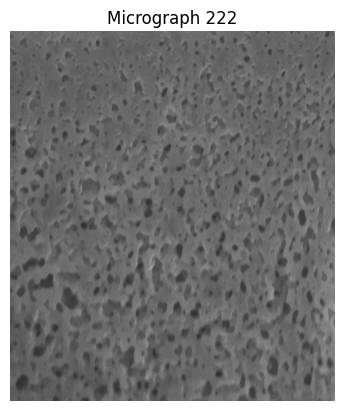

Dimensions: 2
Shape: (899, 1024)
Elements: 920576
Ones: 767163, Zeros: 153413, Total: 920576
Ones: 83.3 %, Zeros: 16.7, Total: 100.0


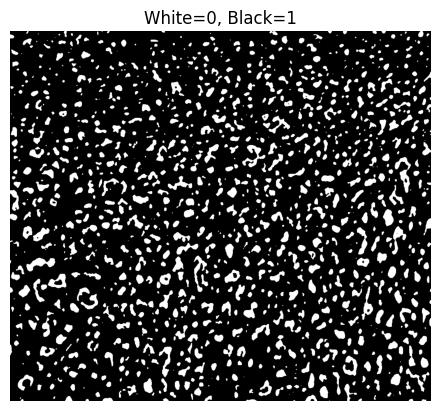

In [10]:
# ==========================================
# 0. Segment a random original FIB-SEM micrograph image, calculate porosity to replicate in the 3D construct

from skimage import io
import matplotlib.pyplot as plt

# I opened originaldata.tif 407 images set in Windows 10, saved image 222 as png
image_path = "micrograph_222.png"

# Read the micrograph image as a NumPy array
image = io.imread(image_path)
print(f"Image Dimensions: {image.shape}")

# Plot the micrograph image
plt.imshow(image)
plt.axis('off')  # Optional: hides the x and y axis coordinates
plt.title("Micrograph 222")
plt.show()

# Segment micrograph image
micrograph_segmented = process_image(image_path)
micrograph_segmented_porosity = round(matrix_bin_stats(micrograph_segmented),3)

# Plotting the micrograph_segmented 0-1 array with 0=White and 1=Black
plt.imshow(micrograph_segmented, cmap='gray_r')
plt.title("White=0, Black=1")
plt.axis('off')
plt.show()


In [11]:
# ==========================================
# 1. 3-D matrix (A1) with the same size as that of the original FIB-SEM structure 
#    (1024×899×400 pixels) was generated to represent the membrane (pg 6)
#    In this case, 3D porosity same % as porosity of 2D input image

import numpy as np

p_zeros = micrograph_segmented_porosity
shape = (1024, 899, 400)

# If random number is LESS than p_zeros, it becomes a 0.
# Otherwise, it becomes a 1.
A1_matrix = (np.random.random(shape) >= p_zeros).astype(np.uint8)

matrix_bin_stats(A1_matrix)

Dimensions: 3
Shape: (1024, 899, 400)
Elements: 368230400
Ones: 306734755, Zeros: 61495645, Total: 368230400
Ones: 83.3 %, Zeros: 16.7, Total: 100.0


0.1670031724702795

In [12]:
# ==========================================
# 2. filter (A1) with a 3-D Gaussian smoothing kernel with standard deviation sigma_1 (pg 7)

from scipy.ndimage import gaussian_filter
import numpy as np

# Assuming 'matrix' is your 1024x899x400 random 0/1 array
# Define your standard deviation sigma_1
sigma_1 = 0.5  # Example value
### LATER HYPERPARAMETER TUNING ###

# Apply the 3D Gaussian filter
# 'mode' handles boundary conditions (default is 'reflect')
A1_matrix_sigma_1 = gaussian_filter(A1_matrix.astype(np.float32), sigma=sigma_1, mode='wrap') # modes: reflect, constant, nearest, mirror, wrap
A1_matrix_sigma_1 = normalize(A1_matrix_sigma_1)
# consider cupyx.scipy.ndimage.gaussian_filter

matrix_non_bin_stats(A1_matrix_sigma_1)


Dimensions: 3
Shape: (1024, 899, 400)
Elements: 368230400
Range 0.0 to 0.2: 0.1 % elements
Range 0.2 to 0.4: 8.4 % elements
Range 0.4 to 0.6: 8.1 % elements
Range 0.6 to 0.8: 5.2 % elements
Range 0.8 to 1.0: 78.1 % elements


In [13]:
# ==========================================
# 3. second matrix (A2) was generated to account for depth-dependent anisotropy in pore size
#    with the same dimensions as (A1) (pg 7)
#    In this case, 3D porosity same % as porosity of 2D input image

import numpy as np

p_zeros = micrograph_segmented_porosity
shape = (1024, 899, 400)

# If random number is LESS than p_zeros, it becomes a 0.
# Otherwise, it becomes a 1.
A2_matrix = (np.random.random(shape) >= p_zeros).astype(np.uint8)

matrix_bin_stats(A2_matrix)

Dimensions: 3
Shape: (1024, 899, 400)
Elements: 368230400
Ones: 306731495, Zeros: 61498905, Total: 368230400
Ones: 83.3 %, Zeros: 16.7, Total: 100.0


0.16701202562308815

In [ ]:
# ==========================================
# 4. filter (A2) with a 3-D Gaussian smoothing kernel with larger standard deviation sigma_2 
#    to represent the larger pores occurring towards the bottom of the membrane (pg 7)

from scipy.ndimage import gaussian_filter

# Assuming 'matrix' is your 1024x899x400 random 0/1 array
# Define your standard deviation sigma_2
k_sigma = 1.2                # Example value
### LATER HYPERPARAMETER TUNING ###
sigma_2 = sigma_1 * k_sigma  

# Apply the 3D Gaussian filter
# 'mode' handles boundary conditions (default is 'reflect')
A2_matrix_sigma_2 = gaussian_filter(A2_matrix.astype(np.float32), sigma=sigma_2)
A2_matrix_sigma_2 = normalize(A2_matrix_sigma_2)
# consider cupyx.scipy.ndimage.gaussian_filter

matrix_non_bin_stats(A2_matrix_sigma_2)

Dimensions: 3
Shape: (1024, 899, 400)
Elements: 368230400
Range 0.0 to 0.2: 11.2 % elements
Range 0.2 to 0.4: 5.5 % elements
Range 0.4 to 0.6: 0.0 % elements
Range 0.6 to 0.8: 0.0 % elements
Range 0.8 to 1.0: 83.3 % elements


In [15]:
# ==========================================
# 5. Create weight matrix W (1024×899×400), Weight function: W(z) = (1 - z/h)^10
#    z-direction is from the top of the membrane with small pores to the bottom of the membrane with large pores
#    h is total height (1024 pixels). Constant in x-y plane, varies only in z-direction (pg27)

# Generate the Z-dimension profile
# First, we generate a 1D array representing the values of the function for each index \(z\) from 0 to 1023, 
# using floating-point division. 
z_indices = np.arange(1024, dtype=np.float32)
W_profile = (1.0 - z_indices / 1024.0)**10
# Expand to 3D matrix using broadcasting
# We reshape the 1D profile array to have shape \((1024,1,1)\). This allows NumPy to automatically "broadcast" 
# these values across the other two dimensions (899 and 400) when a matrix of the final desired shape is requested.
W_profile_reshaped = W_profile[:, np.newaxis, np.newaxis]
W = np.broadcast_to(W_profile_reshaped, (1024, 899, 400))

matrix_non_bin_stats(W)

Dimensions: 3
Shape: (1024, 899, 400)
Elements: 368230400
Range 0.0 to 0.2: 85.1 % elements
Range 0.2 to 0.4: 6.2 % elements
Range 0.4 to 0.6: 3.8 % elements
Range 0.6 to 0.8: 2.7 % elements
Range 0.8 to 1.0: 2.2 % elements


In [16]:
# ==========================================
# 6. Combine matrices to create A_T (pg 27)
#    A_T = A₁ .* W + A₂ .* (1 - W)
#    Element-wise multiplication
A_T = (A1_matrix_sigma_1 * W) + (A2_matrix_sigma_2 * (1.0 - W))

matrix_non_bin_stats(A_T)

Dimensions: 3
Shape: (1024, 899, 400)
Elements: 368230400
Range 0.0 to 0.2: 0.0 % elements
Range 0.2 to 0.4: 0.7 % elements
Range 0.4 to 0.6: 10.5 % elements
Range 0.6 to 0.8: 20.9 % elements
Range 0.8 to 1.0: 67.9 % elements


In [ ]:
# ==========================================
# 6_add1. filter (A_T) with a 3-D Gaussian smoothing kernel with standard deviation sigma_T
#    to represent the larger pores occurring towards the bottom of the membrane (pg 7)
sigma_T = np.mean([sigma_1, sigma_2])
A_T_sigma_T = gaussian_filter(A_T.astype(np.float32), sigma=sigma_T)
A_T_sigma_T = normalize(A_T_sigma_T)

matrix_non_bin_stats(A_T_sigma_T)

Dimensions: 3
Shape: (1024, 899, 400)
Elements: 368230400
Ones: 272707683, Zeros: 95522717, Total: 368230400
Ones: 74.1 %, Zeros: 25.9, Total: 100.0


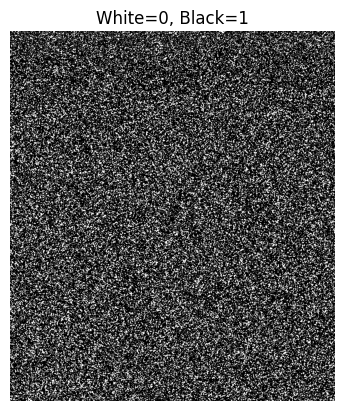

In [18]:
# ==========================================
# 7. Apply adaptive threshold to binarize A_T_sigma_T:
#    If A_T(pixel) > adaptive threshold → solid (1)
#    If A_T(pixel) ≤ adaptive threshold → void (0)
# np.int8 is used for memory efficiency

A_T_binary = matrix_adaptive_threshold(A_T_sigma_T).astype(np.int8)

matrix_bin_stats(A_T_binary)

# Plotting with 0=White and 1=Black a random 2D section of 3D A_T_binary 0-1 array
plt.imshow(A_T_binary[:,:,222], cmap='gray_r')
plt.title("White=0, Black=1")
plt.axis('off')
plt.show()

Dimensions: 3
Shape: (1024, 899, 400)
Elements: 368230400
Ones: 337723281, Zeros: 30507119, Total: 368230400
Ones: 91.7 %, Zeros: 8.3, Total: 100.0


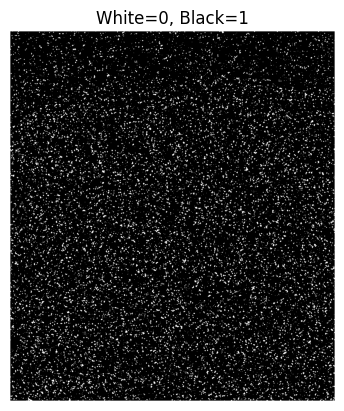

In [19]:
# ==========================================
# 8. Morphological closing (MATLAB's imclose)
#    Use spherical structuring element with radius r_struct, physical radius in pixels
#    Smooths sharp corners, makes pores more circular

from scipy.ndimage import binary_closing
from skimage.morphology import ball
import numpy as np

# Define your hyperparameter (radius in pixels)
# If r_str is a percentage of the dimension, scale it:
r_struct = 1 # radius in pixels, integer
### LATER HYPERPARAMETER TUNING ###

# Create a spherical structuring element (equivalent to MATLAB's strel('sphere', r))
# This returns a 3D boolean array of shape (2*r+1, 2*r+1, 2*r+1)
struct_elem = ball(r_struct)

# Apply the 3D binary closing
# Using A_T_binary (1024x899x400) from previous steps
closed_matrix = binary_closing(A_T_binary, structure=struct_elem)
# consider cupyx.scipy.ndimage.binary_closing

matrix_bin_stats(closed_matrix)

# Plotting with 0=White and 1=Black a random 2D section of 3D A_T_binary 0-1 array
plt.imshow(closed_matrix[:,:,222], cmap='gray_r')
plt.title("White=0, Black=1")
plt.axis('off')
plt.show()

In [20]:
# ==========================================
# Binary 3D structure: 1024×899×400 matrix (values 0 or 1)
# 0 = pore/void, 1 = solid
A_T_morph_closing = closed_matrix

In [ ]:
end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")
# Elapsed time: 209.1900 seconds

Elapsed time: 209.1900 seconds


In [22]:
import gc
# Force the garbage collector to find and free unreferenced objects
gc.collect() 


2758